# NNS Proposal Visualization

## Fetch and Clean Data

In [110]:
import pandas as pd
import numpy as np
import requests
import warnings
import json
import pickle
import stylecloud
import matplotlib.pyplot as plotly
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import regex
import nltk
import string

from wordcloud import WordCloud
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
from pprint import pprint
from tqdm import tqdm
from multiprocessing.pool import ThreadPool
from operator import itemgetter
from PIL import Image
from nltk.tokenize import word_tokenize

warnings.filterwarnings('ignore')
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/crinstaniev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [83]:
base_url = 'https://ic-api.internetcomputer.org'


In [4]:
# get total proposal counts
res = requests.get(f'{base_url}/api/nns/proposals-count')
proposals_count = json.loads(res.text)['proposals_count']

print(f'Total Proposals: {proposals_count}')


Total Proposals: 84904


In [5]:
# fetch proposals
def get_proposal(id):
    url = base_url + '/api/v3/proposals/' + str(id)
    res = requests.get(url)
    res_dict = json.loads(res.text)
    return res_dict


def get_neuron(id):
    url = f'https://ic-api.internetcomputer.org/api/v3/neurons/{id}'
    res = requests.get(url)
    res_dict = json.loads(res.text)
    return res_dict


In [22]:
proposals = []
proposal_ids = [i for i in range(proposals_count)]


def dummy(id):
    res = get_proposal(id)
    proposals.append(dict(
        id=id,
        data=res
    ))
    print(f'fetched: proposal {id}')

# enable multithreading for faster download
pool = ThreadPool(50)

pool.imap_unordered(dummy, proposal_ids)


In [7]:
pickle.dump(proposals, open('nns_data_raw.pkl', 'wb'))


In [8]:
data = pickle.load(open('nns_data_raw.pkl', 'rb'))
data.sort(key=itemgetter('id'))
json.dump(data, open('proposals.json', 'w'))


In [9]:
# filter empty data
proposals_no_empty = []

for item in data:
    if (item['data'].get('code') != 404):
        proposals_no_empty.append(
            item['data']
        )
json.dump(proposals_no_empty, open('proposals_no_empty.json', 'w'))


In [10]:
df = pd.read_json('proposals_no_empty.json')


In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69989 entries, 0 to 69988
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   action                      69989 non-null  object        
 1   action_nns_function         69142 non-null  object        
 2   deadline_timestamp_seconds  51182 non-null  float64       
 3   decided_timestamp_seconds   69989 non-null  int64         
 4   executed_timestamp_seconds  69983 non-null  float64       
 5   failed_timestamp_seconds    66391 non-null  float64       
 6   id                          69989 non-null  int64         
 7   known_neurons_ballots       69989 non-null  object        
 8   latest_tally                69989 non-null  object        
 9   payload                     69986 non-null  object        
 10  proposal_id                 69989 non-null  int64         
 11  proposal_timestamp_seconds  69989 non-null  int64     

## Wordcloud - Proposal Summary

In [107]:
with open('proposal_summary_text.txt', 'w') as f:
    f.write(' '.join(list(df['summary'].values)))


In [108]:
stylecloud.gen_stylecloud(file_path='proposal_summary_text.txt',
                          icon_name='fas fa-folder',
                          palette='colorbrewer.diverging.Spectral_11',
                          background_color='black',
                          gradient='horizontal',
                          output_name='proposal_summary_wordcloud.png',
                          size=1024)


In [109]:
# cleaning data for wordcloud
df_wordcloud = df[['topic', 'summary']]
df_wordcloud = df_wordcloud.groupby('topic').aggregate(' '.join).reset_index()
df_wordcloud.to_csv('topic_summary_joined.csv')

# remove non-utf8 characters


def remove_non_utf8(x: str):
    x = x.encode('utf-8', errors='ignore').decode('utf-8')
    x = regex.sub(r'[^\x00-\x7f]', u'', x)
    x = regex.sub(r"http\S+", "", x)
    x = x.translate(str.maketrans('', '', string.punctuation))
    x = word_tokenize(x)
    x = [word for word in x if not word in stopwords.words('english')]

    return (" ").join(x)


df_wordcloud['summary'] = df_wordcloud['summary'].apply(remove_non_utf8)
df_wordcloud.to_csv('topic_summary_joined.csv')
df_wordcloud


,topic,summary
0,TOPIC_EXCHANGE_RATE,The ICPXDR conversion rate set 404904 The ICPX...
1,TOPIC_GOVERNANCE,SetAuthorizedSubnetworks SetAuthorizedSubnetwo...
2,TOPIC_KYC,The proposal unlocks neurons associated listed...
3,TOPIC_NETWORK_CANISTER_MANAGEMENT,Upgrade ledger canister git commit 8a560f9510b...
4,TOPIC_NETWORK_ECONOMICS,ClearProvisionalWhitelist Initialize rewards t...
5,TOPIC_NODE_ADMIN,Remove nodes registry Remove nodes registry Re...
6,TOPIC_NODE_PROVIDER_REWARDS,Proposal mint 1 ICP node provider reward sixix...
7,TOPIC_PARTICIPANT_MANAGEMENT,Add node provider Blockchange Ventures II prin...
8,TOPIC_SUBNET_MANAGEMENT,Add verifiedapplication subnet number 5 commit...


In [186]:
def generate_wordcloud(df_wordcloud, topics):

    words = []
    for topic in topics:
        words.append(
            df_wordcloud.query(f"topic == '{topic}'")['summary'].values[0]
        )

    all_words = (' ').join(words)

    with open('all_words.txt', 'w') as f:
        f.write(all_words)

    wc = WordCloud(
        background_color='black',
        repeat=True,
        width=1024 * 2,
        height=768 * 2,
        max_words=200,
        colormap='Set2',
        font_path='impact.ttf'
    )
    wc.generate(all_words)

    return wc


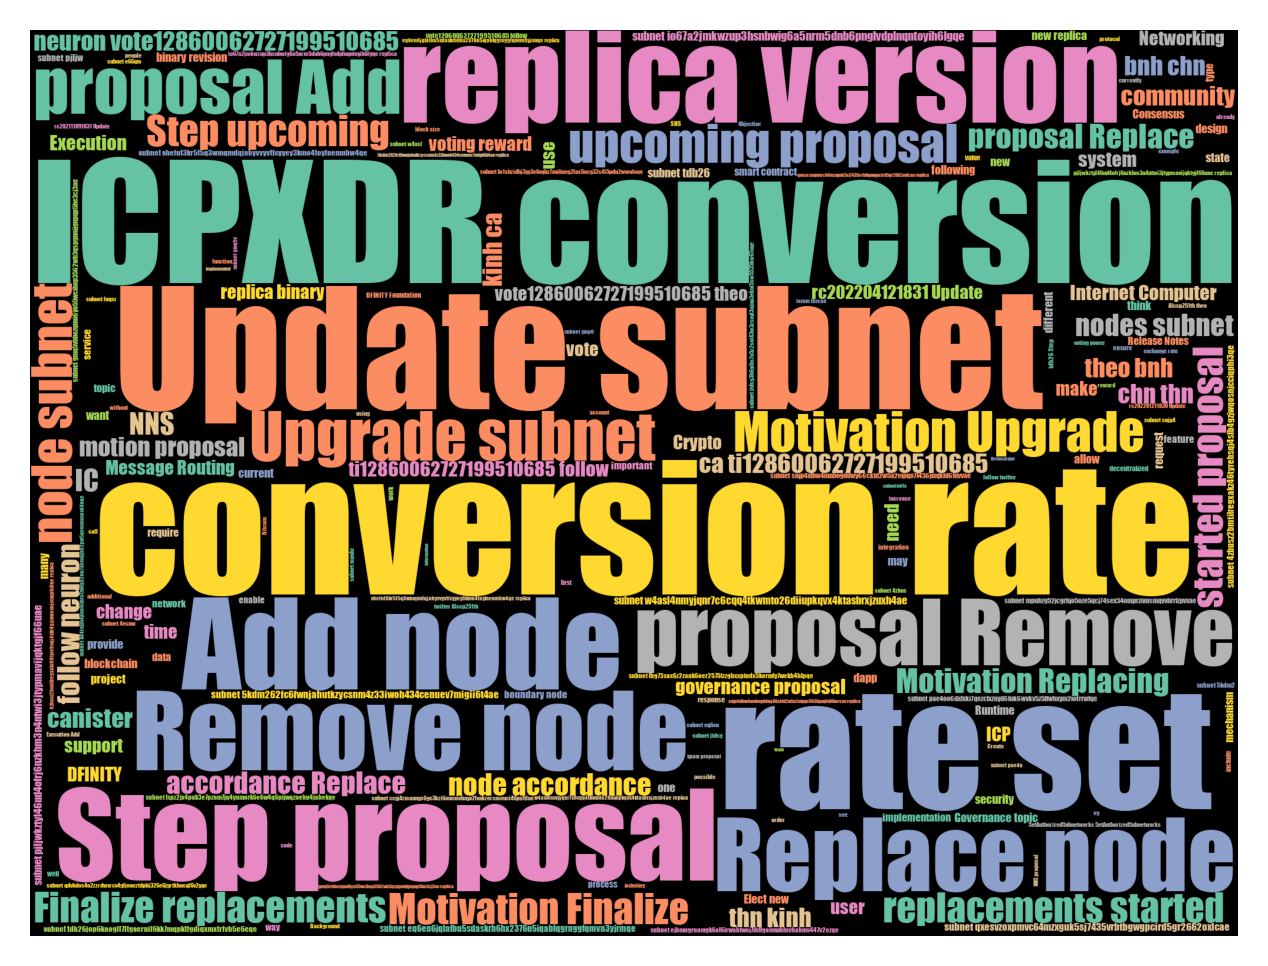

In [187]:
wc = generate_wordcloud(
    df_wordcloud=df_wordcloud,
    topics=[
        'TOPIC_EXCHANGE_RATE',
        'TOPIC_GOVERNANCE',
        # 'TOPIC_KYC',
        # 'TOPIC_NETWORK_CANISTER_MANAGEMENT',
        # 'TOPIC_NETWORK_ECONOMICS',
        # 'TOPIC_NODE_ADMIN',
        # 'TOPIC_NODE_PROVIDER_REWARDS',
        # 'TOPIC_PARTICIPANT_MANAGEMENT',
        'TOPIC_SUBNET_MANAGEMENT',
    ]
)
plt.figure(dpi=300)
plt.axis('off')
plt.imshow(wc)
plt.show()


## Area Chart - Topics River

In [14]:
topic_time_df = df[['proposal_id', 'topic',
                    'updated_at']].set_index('proposal_id')

topic_time_df['updated_at'] = topic_time_df['updated_at'].dt.floor('d')

topic_time_stats = topic_time_df.groupby(
    'updated_at').value_counts().reset_index()
topic_time_stats.columns = ['date', 'topic', 'count']
topic_time_stats


,date,topic,count
0,2021-08-05,TOPIC_EXCHANGE_RATE,265
1,2021-08-05,TOPIC_SUBNET_MANAGEMENT,100
2,2021-08-05,TOPIC_NODE_PROVIDER_REWARDS,100
3,2021-08-05,TOPIC_GOVERNANCE,86
4,2021-08-05,TOPIC_NETWORK_CANISTER_MANAGEMENT,59
...,...,...,...
1135,2022-10-05,TOPIC_EXCHANGE_RATE,143
1136,2022-10-06,TOPIC_EXCHANGE_RATE,198
1137,2022-10-06,TOPIC_SUBNET_MANAGEMENT,47
1138,2022-10-06,TOPIC_NETWORK_CANISTER_MANAGEMENT,3


In [15]:
fig = px.area(topic_time_stats, x='date', y='count',
              color='topic', template='plotly_dark')
fig.update_yaxes(type='log', range=[0, 4])
fig.show()


In [16]:
px.data.gapminder()

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,AFG,4
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,AFG,4
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,AFG,4
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,AFG,4
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,AFG,4
...,...,...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306,ZWE,716
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,ZWE,716
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,ZWE,716
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,ZWE,716


In [17]:
topic_time_df = df[['proposal_id', 'topic',
                    'updated_at']].set_index('proposal_id')

topic_time_df['updated_at'] = topic_time_df['updated_at'].dt.floor('d')

topic_time_stats = topic_time_df.groupby(
    'updated_at').value_counts().unstack(fill_value=0).reset_index()
topics = list(topic_time_stats.columns[1:])

topic_time_stats['sum'] = 0

for topic in topics:
    topic_time_stats['sum'] += topic_time_stats[topic]

topic_time_stats


topic,updated_at,TOPIC_EXCHANGE_RATE,TOPIC_GOVERNANCE,TOPIC_KYC,TOPIC_NETWORK_CANISTER_MANAGEMENT,TOPIC_NETWORK_ECONOMICS,TOPIC_NODE_ADMIN,TOPIC_NODE_PROVIDER_REWARDS,TOPIC_PARTICIPANT_MANAGEMENT,TOPIC_SUBNET_MANAGEMENT,sum
0,2021-08-05,265,86,7,59,1,9,100,15,100,642
1,2021-08-06,144,0,0,0,0,0,0,0,8,152
2,2021-08-07,144,0,0,0,0,0,0,0,0,144
3,2021-08-08,144,0,0,0,0,0,0,0,0,144
4,2021-08-09,144,0,0,0,0,0,0,0,1,145
...,...,...,...,...,...,...,...,...,...,...,...
423,2022-10-02,144,1,0,0,0,0,0,0,21,166
424,2022-10-03,144,0,0,0,0,0,0,0,14,158
425,2022-10-04,143,1,0,2,0,0,0,0,1,147
426,2022-10-05,143,0,0,0,0,0,0,0,0,143


In [50]:
from plotly.subplots import make_subplots

# fig = go.Figure()
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

for topic in topics:
    fig.add_trace(go.Scatter(
        x=topic_time_stats['updated_at'],
        y=topic_time_stats[topic],
        mode='lines',
        line=dict(width=0.5),
        stackgroup='one',
        groupnorm='percent',
        name=topic,
    ), row=2, col=1)

fig.add_traces(
    go.Line(x=topic_time_stats['updated_at'], y=topic_time_stats['sum'], name='Sum of all Topics'))

fig.update_layout(dict(template='plotly_dark',
                  title='Proposal Topic Changes Over Time', width=1200, height=800))

# fig.update_layout(yaxis_range=(0, 100))
fig.update_xaxes(title='Time')

fig['layout']['yaxis2'].update(title='Percentage', range=[60, 100])
fig['layout']['yaxis1'].update(title='Count')

# fig.show()
with open('topic_area_chart.html', 'w') as f:
    f.write(fig.to_html())
